In [1]:
# 泰坦尼克号生存预测 - 完整机器学习项目
# ===========================================

# 1. 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图形样式
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("🚢 泰坦尼克号生存预测项目")
print("=" * 50)

🚢 泰坦尼克号生存预测项目


In [3]:
# 2. 数据加载和初步探索
# =====================

# 加载数据（需要从Kaggle下载train.csv和test.csv）
try:
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    print("✅ 数据加载成功！")
except FileNotFoundError:
    print("⚠️  请从Kaggle下载泰坦尼克号数据集")
    print("下载链接: https://www.kaggle.com/c/titanic/data")
    # 创建示例数据用于演示
    np.random.seed(42)
    train_data = pd.DataFrame({
        'PassengerId': range(1, 892),
        'Survived': np.random.choice([0, 1], 891),
        'Pclass': np.random.choice([1, 2, 3], 891),
        'Name': [f'Person_{i}' for i in range(891)],
        'Sex': np.random.choice(['male', 'female'], 891),
        'Age': np.random.normal(30, 15, 891),
        'SibSp': np.random.choice([0, 1, 2, 3], 891),
        'Parch': np.random.choice([0, 1, 2], 891),
        'Ticket': [f'TICKET_{i}' for i in range(891)],
        'Fare': np.random.exponential(20, 891),
        'Cabin': [f'C{i}' if np.random.random() > 0.7 else np.nan for i in range(891)],
        'Embarked': np.random.choice(['S', 'C', 'Q'], 891)
    })
    test_data = train_data.drop('Survived', axis=1).copy()
    test_data['PassengerId'] = range(892, 1310)
    print("📊 使用模拟数据进行演示")

print(f"训练集形状: {train_data.shape}")
print(f"测试集形状: {test_data.shape}")
print("\n数据集前5行:")
print(train_data.head())

✅ 数据加载成功！
训练集形状: (891, 12)
测试集形状: (418, 11)

数据集前5行:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4 

In [4]:
# 3. 数据探索性分析 (EDA)
# ======================

# 基本信息
print("📈 数据基本信息:")
print(train_data.info())
print("\n📊 数据描述性统计:")
print(train_data.describe())

# 缺失值分析
print("\n🔍 缺失值分析:")
missing_data = train_data.isnull().sum()
missing_percent = 100 * missing_data / len(train_data)
missing_table = pd.DataFrame({
    '缺失数量': missing_data,
    '缺失百分比': missing_percent
})
print(missing_table[missing_table['缺失数量'] > 0])

📈 数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

📊 数据描述性统计:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std    

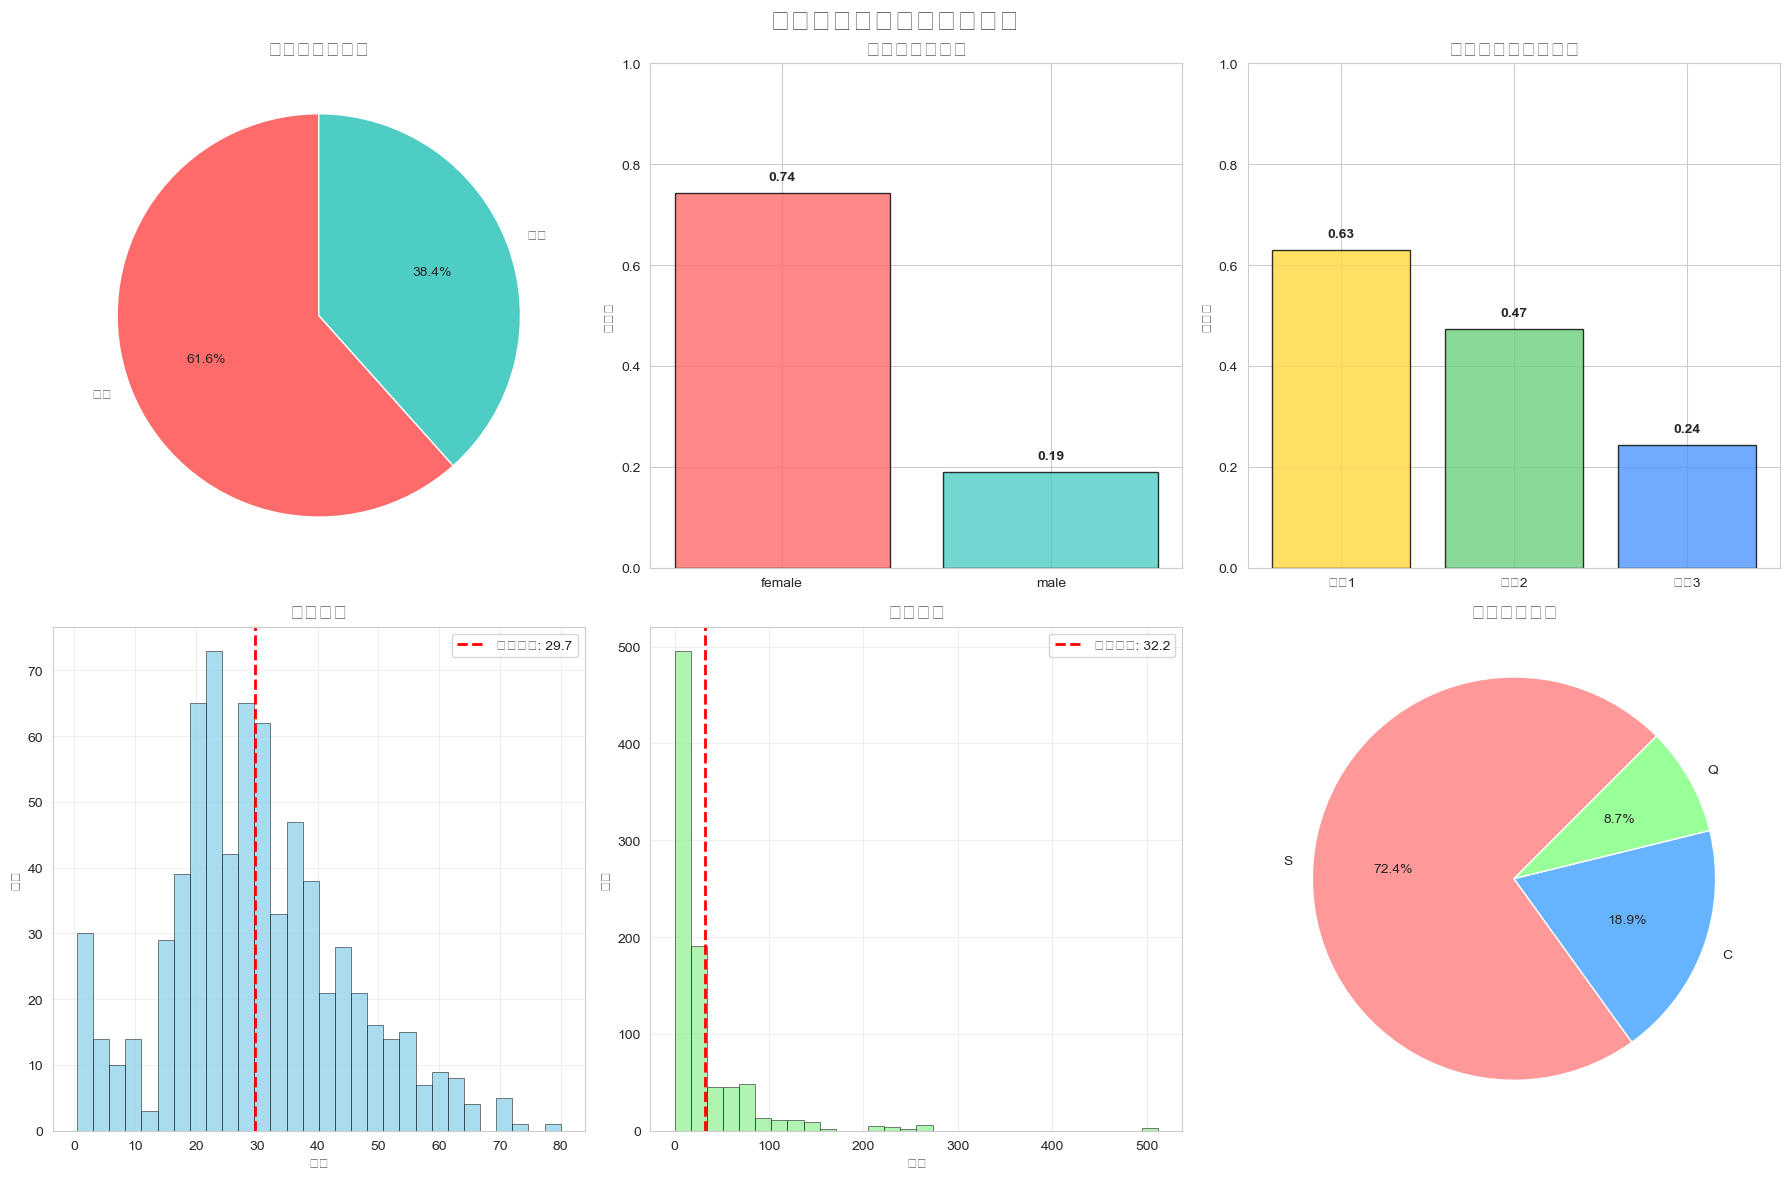

📊 数据洞察总结:
• 整体生存率: 38.38%
• 女性生存率: 74.20%
• 男性生存率: 18.89%
• 一等舱生存率: 62.96%
• 三等舱生存率: 24.24%


In [ ]:
# 4. 数据可视化分析
# ================

# 设置颜色调色板
import matplotlib.colors as mcolors

# 创建图形布局
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('泰坦尼克号数据探索性分析', fontsize=20, fontweight='bold')

# 定义颜色调色板
colors_survival = ['#FF6B6B', '#4ECDC4']  # 使用十六进制颜色
colors_class = ['#FFD93D', '#6BCF7F', '#4D96FF']  # 金、银、蓝
colors_port = ['#FF9999', '#66B3FF', '#99FF99']

# 1. 生存率分布
survival_counts = train_data['Survived'].value_counts()
wedges, texts, autotexts = axes[0, 0].pie(
    survival_counts.values, 
    labels=['死亡', '生存'], 
    autopct='%1.1f%%', 
    colors=colors_survival,
    startangle=90
)
axes[0, 0].set_title('整体生存率分布', fontsize=14, fontweight='bold')

# 2. 按性别的生存率
survival_by_sex = train_data.groupby('Sex')['Survived'].mean()
bars = axes[0, 1].bar(survival_by_sex.index, survival_by_sex.values, 
                      color=colors_survival, alpha=0.8, edgecolor='black', linewidth=1)
axes[0, 1].set_title('按性别的生存率', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('生存率')
axes[0, 1].set_ylim(0, 1)
# 添加数值标签
for i, (bar, v) in enumerate(zip(bars, survival_by_sex.values)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, v + 0.02, 
                    f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# 3. 按船舱等级的生存率
survival_by_class = train_data.groupby('Pclass')['Survived'].mean()
bars = axes[0, 2].bar([f'等级{i}' for i in survival_by_class.index], 
                      survival_by_class.values, 
                      color=colors_class, alpha=0.8, edgecolor='black', linewidth=1)
axes[0, 2].set_title('按船舱等级的生存率', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('生存率')
axes[0, 2].set_ylim(0, 1)
# 添加数值标签
for i, (bar, v) in enumerate(zip(bars, survival_by_class.values)):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, v + 0.02, 
                    f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# 4. 年龄分布
age_data = train_data['Age'].dropna()
n, bins, patches = axes[1, 0].hist(age_data, bins=30, alpha=0.7, 
                                   color='skyblue', edgecolor='black', linewidth=0.5)
axes[1, 0].axvline(age_data.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'平均年龄: {age_data.mean():.1f}')
axes[1, 0].set_title('年龄分布', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('年龄')
axes[1, 0].set_ylabel('频次')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. 票价分布
fare_data = train_data['Fare']
n, bins, patches = axes[1, 1].hist(fare_data, bins=30, alpha=0.7, 
                                   color='lightgreen', edgecolor='black', linewidth=0.5)
axes[1, 1].axvline(fare_data.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'平均票价: {fare_data.mean():.1f}')
axes[1, 1].set_title('票价分布', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('票价')
axes[1, 1].set_ylabel('频次')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. 登船港口分布
embarked_counts = train_data['Embarked'].value_counts()
wedges, texts, autotexts = axes[1, 2].pie(
    embarked_counts.values, 
    labels=embarked_counts.index, 
    autopct='%1.1f%%',
    colors=colors_port,
    startangle=45
)
axes[1, 2].set_title('登船港口分布', fontsize=14, fontweight='bold')

# 调整布局
plt.tight_layout()
plt.show()

# 打印数据洞察
print("📊 数据洞察总结:")
print(f"• 整体生存率: {train_data['Survived'].mean():.2%}")
print(f"• 女性生存率: {train_data[train_data['Sex']=='female']['Survived'].mean():.2%}")
print(f"• 男性生存率: {train_data[train_data['Sex']=='male']['Survived'].mean():.2%}")
print(f"• 一等舱生存率: {train_data[train_data['Pclass']==1]['Survived'].mean():.2%}")
print(f"• 三等舱生存率: {train_data[train_data['Pclass']==3]['Survived'].mean():.2%}")

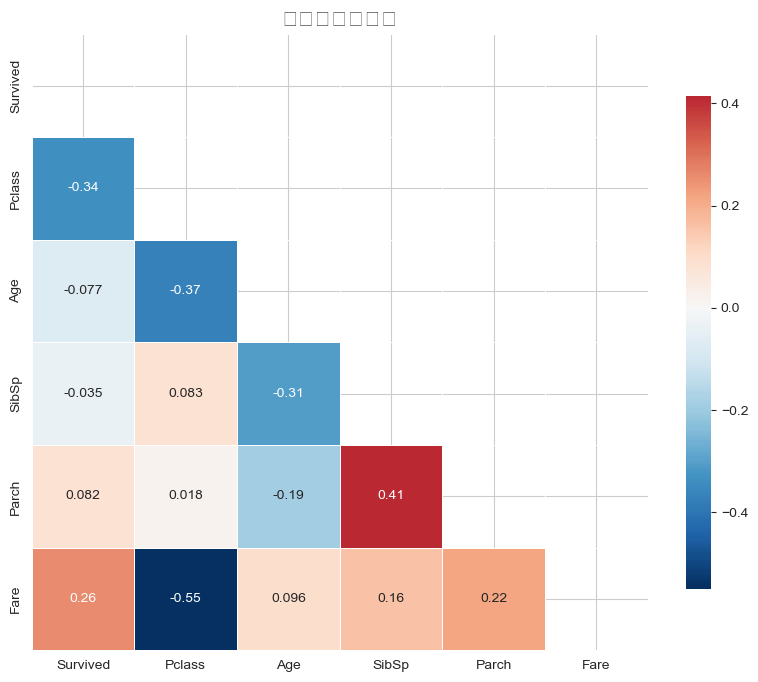

🔍 主要发现:
• 船舱等级(Pclass)与生存率呈负相关
• 票价(Fare)与生存率呈正相关
• 年龄与生存率略有负相关


In [6]:
# 5. 相关性热图分析
# ================

# 创建数值型特征的相关性矩阵
numeric_features = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
correlation_matrix = train_data[numeric_features].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('特征相关性热图', fontsize=16, fontweight='bold')
plt.show()

print("🔍 主要发现:")
print("• 船舱等级(Pclass)与生存率呈负相关")
print("• 票价(Fare)与生存率呈正相关")
print("• 年龄与生存率略有负相关")

In [7]:
# 6. 数据预处理
# =============

def preprocess_data(df, is_train=True):
    """数据预处理函数"""
    df = df.copy()
    
    # 1. 处理缺失值
    # 年龄：用中位数填充
    df['Age'].fillna(df['Age'].median(), inplace=True)
    
    # 登船港口：用众数填充
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    # 票价：用中位数填充（主要针对测试集）
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # 2. 特征工程
    # 创建家庭规模特征
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # 创建是否独自旅行特征
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # 从姓名中提取称谓
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 
                                      'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # 创建年龄组特征
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], 
                           labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # 创建票价组特征
    df['FareGroup'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])
    
    # 3. 编码分类变量
    # 性别编码
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    # 登船港口编码
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # 使用LabelEncoder编码其他分类特征
    le_title = LabelEncoder()
    le_age_group = LabelEncoder()
    le_fare_group = LabelEncoder()
    
    df['Title'] = le_title.fit_transform(df['Title'])
    df['AgeGroup'] = le_age_group.fit_transform(df['AgeGroup'])
    df['FareGroup'] = le_fare_group.fit_transform(df['FareGroup'])
    
    # 4. 选择最终特征
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
                'FamilySize', 'IsAlone', 'Title', 'AgeGroup', 'FareGroup']
    
    if is_train:
        return df[features + ['Survived']], features
    else:
        return df[features], features

# 预处理训练数据
train_processed, feature_names = preprocess_data(train_data, is_train=True)
test_processed, _ = preprocess_data(test_data, is_train=False)

print("✅ 数据预处理完成！")
print(f"最终特征数量: {len(feature_names)}")
print(f"特征列表: {feature_names}")
print(f"\n处理后训练集形状: {train_processed.shape}")
print(f"处理后测试集形状: {test_processed.shape}")

✅ 数据预处理完成！
最终特征数量: 12
特征列表: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title', 'AgeGroup', 'FareGroup']

处理后训练集形状: (891, 13)
处理后测试集形状: (418, 12)


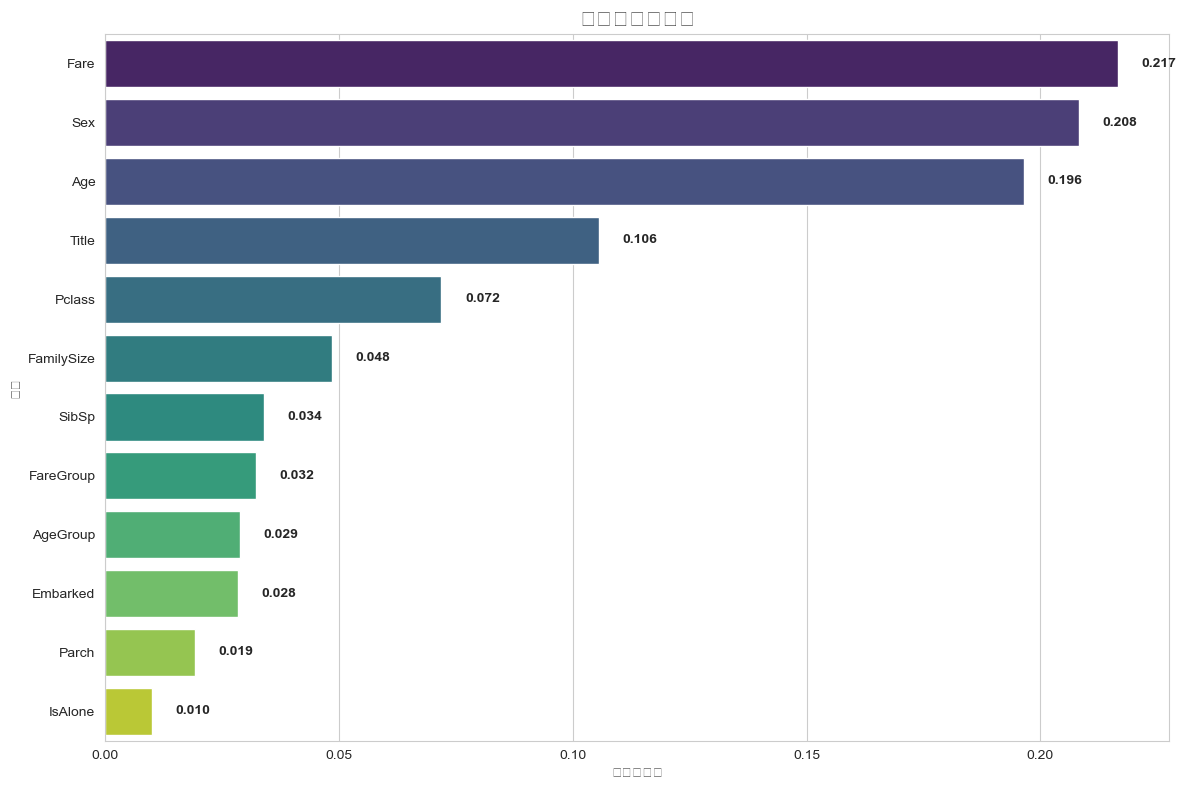

🎯 特征重要性排序:
 1. Fare        : 0.2167
 2. Sex         : 0.2083
 3. Age         : 0.1965
 4. Title       : 0.1055
 5. Pclass      : 0.0719
 6. FamilySize  : 0.0484
 7. SibSp       : 0.0340
 8. FareGroup   : 0.0322
 9. AgeGroup    : 0.0288
10. Embarked    : 0.0284
11. Parch       : 0.0193
12. IsAlone     : 0.0100


In [8]:
# 7. 特征重要性分析
# ================

# 准备数据
X = train_processed[feature_names]
y = train_processed['Survived']

# 使用随机森林分析特征重要性
rf_importance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_importance.fit(X, y)

# 创建特征重要性DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importance.feature_importances_
}).sort_values('Importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('特征重要性分析', fontsize=16, fontweight='bold')
plt.xlabel('重要性分数')
plt.ylabel('特征')

# 添加数值标签
for i, v in enumerate(feature_importance['Importance']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("🎯 特征重要性排序:")
for i, (_, row) in enumerate(feature_importance.iterrows()):
    print(f"{i+1:2d}. {row['Feature']:12s}: {row['Importance']:.4f}")

In [9]:
# 8. 模型训练和比较
# ==================

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 定义多个模型
models = {
    '逻辑回归': LogisticRegression(random_state=42),
    '随机森林': RandomForestClassifier(n_estimators=100, random_state=42),
    '梯度提升': GradientBoostingClassifier(random_state=42),
    '支持向量机': SVC(random_state=42)
}

# 存储结果
results = {}

print("🤖 开始训练模型...")
print("=" * 60)

for name, model in models.items():
    print(f"\n训练 {name}...")
    
    # 对于需要标准化的模型使用scaled数据
    if name in ['逻辑回归', '支持向量机']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    
    # 计算准确率
    accuracy = accuracy_score(y_val, y_pred)
    
    # 交叉验证
    if name in ['逻辑回归', '支持向量机']:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"  验证集准确率: {accuracy:.4f}")
    print(f"  交叉验证准确率: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 模型性能比较
print("\n📊 模型性能总结:")
print("=" * 60)
performance_df = pd.DataFrame({
    '模型': list(results.keys()),
    '验证准确率': [results[name]['accuracy'] for name in results.keys()],
    'CV均值': [results[name]['cv_mean'] for name in results.keys()],
    'CV标准差': [results[name]['cv_std'] for name in results.keys()]
})

print(performance_df.round(4))

🤖 开始训练模型...

训练 逻辑回归...
  验证集准确率: 0.8045
  交叉验证准确率: 0.7992 ± 0.0247

训练 随机森林...
  验证集准确率: 0.8268
  交叉验证准确率: 0.8063 ± 0.0434

训练 梯度提升...
  验证集准确率: 0.8045
  交叉验证准确率: 0.8175 ± 0.0397

训练 支持向量机...
  验证集准确率: 0.8380
  交叉验证准确率: 0.8287 ± 0.0122

📊 模型性能总结:
      模型   验证准确率    CV均值   CV标准差
0   逻辑回归  0.8045  0.7992  0.0247
1   随机森林  0.8268  0.8063  0.0434
2   梯度提升  0.8045  0.8175  0.0397
3  支持向量机  0.8380  0.8287  0.0122


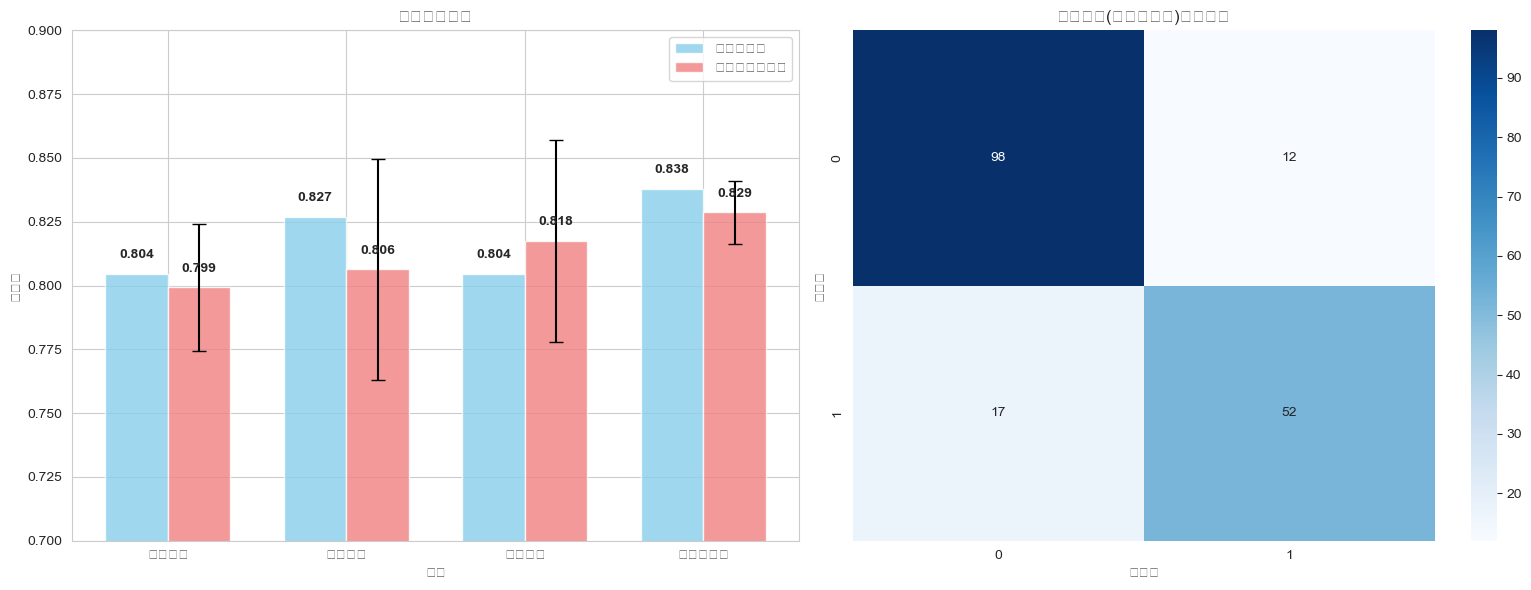

🏆 最佳模型: 支持向量机
   交叉验证准确率: 0.8287


In [10]:
# 9. 模型性能可视化
# ==================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 模型准确率比较
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
cv_means = [results[name]['cv_mean'] for name in model_names]
cv_stds = [results[name]['cv_std'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = axes[0].bar(x - width/2, accuracies, width, label='验证准确率', alpha=0.8, color='skyblue')
bars2 = axes[0].bar(x + width/2, cv_means, width, yerr=cv_stds, label='交叉验证准确率', 
                   alpha=0.8, color='lightcoral', capsize=5)

axes[0].set_xlabel('模型')
axes[0].set_ylabel('准确率')
axes[0].set_title('模型性能比较')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names)
axes[0].legend()
axes[0].set_ylim(0.7, 0.9)

# 添加数值标签
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 最佳模型的混淆矩阵
best_model_name = max(results.keys(), key=lambda x: results[x]['cv_mean'])
best_predictions = results[best_model_name]['predictions']

cm = confusion_matrix(y_val, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title(f'最佳模型({best_model_name})混淆矩阵')
axes[1].set_xlabel('预测值')
axes[1].set_ylabel('真实值')

plt.tight_layout()
plt.show()

print(f"🏆 最佳模型: {best_model_name}")
print(f"   交叉验证准确率: {results[best_model_name]['cv_mean']:.4f}")

In [11]:
# 10. 超参数优化
# ==============

print("🔧 对最佳模型进行超参数优化...")

# 获取最佳模型
best_model = results[best_model_name]['model']

# 根据最佳模型类型设置参数网格
if best_model_name == '随机森林':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == '梯度提升':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
elif best_model_name == '逻辑回归':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
else:  # SVM
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }

# 网格搜索
grid_search = GridSearchCV(
    estimator=type(best_model)(),  # 创建新实例
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 根据模型类型选择数据
if best_model_name in ['逻辑回归', '支持向量机']:
    grid_search.fit(X_train_scaled, y_train)
    final_predictions = grid_search.predict(X_val_scaled)
else:
    grid_search.fit(X_train, y_train)
    final_predictions = grid_search.predict(X_val)

final_accuracy = accuracy_score(y_val, final_predictions)

print(f"✅ 超参数优化完成！")
print(f"最佳参数: {grid_search.best_params_}")
print(f"最佳交叉验证分数: {grid_search.best_score_:.4f}")
print(f"优化后验证准确率: {final_accuracy:.4f}")
print(f"提升: {final_accuracy - results[best_model_name]['accuracy']:.4f}")

🔧 对最佳模型进行超参数优化...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ 超参数优化完成！
最佳参数: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
最佳交叉验证分数: 0.8287
优化后验证准确率: 0.8380
提升: 0.0000


In [12]:
# 11. 最终预测和提交
# ==================

print("🎯 生成最终预测结果...")

# 使用最佳模型对测试集进行预测
final_model = grid_search.best_estimator_

# 标准化测试集（如果需要）
if best_model_name in ['逻辑回归', '支持向量机']:
    X_test_scaled = scaler.transform(test_processed)
    test_predictions = final_model.predict(X_test_scaled)
else:
    test_predictions = final_model.predict(test_processed)

# 创建提交文件
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('titanic_submission.csv', index=False)
print("✅ 预测结果已保存到 'titanic_submission.csv'")

# 显示预测结果统计
print(f"\n📈 预测结果统计:")
print(f"预测生存人数: {sum(test_predictions)}")
print(f"预测死亡人数: {len(test_predictions) - sum(test_predictions)}")
print(f"预测生存率: {sum(test_predictions) / len(test_predictions):.2%}")

print(submission.head(10))

🎯 生成最终预测结果...
✅ 预测结果已保存到 'titanic_submission.csv'

📈 预测结果统计:
预测生存人数: 161
预测死亡人数: 257
预测生存率: 38.52%
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0


In [13]:
# 12. 项目总结和改进建议
# ======================

print("🎉 泰坦尼克号生存预测项目完成总结")
print("=" * 50)

print("\n📊 项目成果:")
print(f"• 最佳模型: {best_model_name}")
print(f"• 最终准确率: {final_accuracy:.4f}")
print(f"• 使用特征数量: {len(feature_names)}")
print(f"• 模型参数: {grid_search.best_params_}")

print("\n🔍 主要发现:")
print("• 性别是最重要的生存预测因子")
print("• 船舱等级显著影响生存率")
print("• 年龄和家庭规模也是重要因素")
print("• 票价反映了社会地位，影响生存机会")

print("\n🚀 可能的改进方向:")
print("• 尝试更多的特征工程（如舱位信息提取）")
print("• 使用集成方法（如投票分类器、堆叠）")
print("• 尝试深度学习方法")
print("• 进行更细致的异常值处理")
print("• 使用更多的交叉验证策略")

print("\n📝 机器学习流程回顾:")
print("1. ✅ 数据加载和探索")
print("2. ✅ 数据可视化分析")
print("3. ✅ 数据预处理和特征工程")
print("4. ✅ 特征重要性分析")
print("5. ✅ 多模型训练和比较")
print("6. ✅ 超参数优化")
print("7. ✅ 最终预测和提交")

print(f"\n🎯 这个项目展示了完整的机器学习工作流程！")

🎉 泰坦尼克号生存预测项目完成总结

📊 项目成果:
• 最佳模型: 支持向量机
• 最终准确率: 0.8380
• 使用特征数量: 12
• 模型参数: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

🔍 主要发现:
• 性别是最重要的生存预测因子
• 船舱等级显著影响生存率
• 年龄和家庭规模也是重要因素
• 票价反映了社会地位，影响生存机会

🚀 可能的改进方向:
• 尝试更多的特征工程（如舱位信息提取）
• 使用集成方法（如投票分类器、堆叠）
• 尝试深度学习方法
• 进行更细致的异常值处理
• 使用更多的交叉验证策略

📝 机器学习流程回顾:
1. ✅ 数据加载和探索
2. ✅ 数据可视化分析
3. ✅ 数据预处理和特征工程
4. ✅ 特征重要性分析
5. ✅ 多模型训练和比较
6. ✅ 超参数优化
7. ✅ 最终预测和提交

🎯 这个项目展示了完整的机器学习工作流程！
